In [1]:
# code taken from the following website;
# https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02

from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
import csv 
import matplotlib.dates as mdates


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from datetime import datetime

In [ ]:
tf.random.set_seed(1234)

In [2]:
# reading the file
data = pd.read_csv('Data\daily_sales - Copy.csv',)

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

In [3]:
# filtering dataset by date column

data = data.loc['2017-04-01':'2021-12-01']




In [ ]:
df = data.resample('W').agg({'Sales':'sum', 'Dollar to Pkr':'mean', 'Daily Cases':'sum'})


In [ ]:
data['Sales_mavg'] = data['Sales'].rolling(window=14).mean()         # weekly average

In [ ]:
data = data.loc['2017-06-01':'2021-12-01']


In [ ]:
data

In [ ]:
# view data

plt.figure(figsize=(20,10))
axes = plt.gca()



plt.plot(data.index, data['Sales_mavg'], color='red')
plt.plot(data.index, data['Sales'], color='orange')
plt.plot(data.index, data['Daily Cases'], color='blue')
plt.plot(data.index, data['Dollar to Pkr'], color='purple')

plt.scatter(data.index, data['Sales_mavg'], color='red')
plt.scatter(data.index, data['Sales'], color='orange')
plt.scatter(data.index, data['Daily Cases'], color='blue')
plt.scatter(data.index, data['Dollar to Pkr'], color='purple')

plt.xlabel('Time (Weekly)', {'fontsize': 12}) 
plt.ylabel('Sales Moving avg', {'fontsize': 12})


In [ ]:
# check null values
a = data.isnull()
b = a.sum()
type(b)
for x in range(len(b)):
    print(b[x])
    

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(data['Dollar to Pkr'])

In [ ]:
# check for missing values again
data.isnull().sum()

In [ ]:
# Outlier detection
# for now adjusting the sales column only
# up_b = data['Sales'].mean() + 2*data['Sales'].std()
# low_b = data['Sales'].mean() - 2*data['Sales'].std()

# data.loc[data['Sales'] > up_b, 'Sales'] = np.nan
# data.loc[data['Sales'] < low_b, 'Sales'] = np.nan
# data['Sales'].interpolate(inplace=True)


# up_b = data['Sales_mavg'].mean() + 2*data['Sales_mavg'].std()
# low_b = data['Sales_mavg'].mean() - 2*data['Sales_mavg'].std()

# data.loc[data['Sales_mavg'] > up_b, 'Sales_mavg'] = np.nan
# data.loc[data['Sales_mavg'] < low_b, 'Sales_mavg'] = np.nan
# data['Sales_mavg'].interpolate(inplace=True)


# according to my understanding, the dependent variables should also get adjusted

# up_b = data['Dollar to Pkr'].mean() + 2*data['Dollar to Pkr'].std()
# low_b = data['Dollar to Pkr'].mean() - 2*data['Dollar to Pkr'].std()

# data.loc[data['Dollar to Pkr'] > up_b, 'Dollar to Pkr'] = np.nan
# data.loc[data['Dollar to Pkr'] < low_b, 'Dollar to Pkr'] = np.nan
# data['Dollar to Pkr'].interpolate(inplace=True)

# up_b = data['Weekly Cases'].mean() + 2*data['Weekly Cases'].std()
# low_b = data['Weekly Cases'].mean() - 2*data['Weekly Cases'].std()

# data.loc[data['Weekly Cases'] > up_b, 'Weekly Cases'] = np.nan
# data.loc[data['Weekly Cases'] < low_b, 'Weekly Cases'] = np.nan
# data['Weekly Cases'].interpolate(inplace=True)

Dimension of train data:  (1215, 2)
Dimension of test data:  (304, 2)


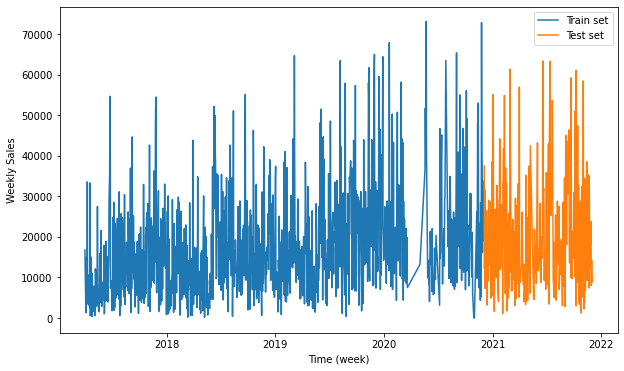

In [4]:
# Split train data and test data 80 - 20
train_size = int(len(data)*0.8)
train_dataset, test_dataset = data.iloc[:train_size],data.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.Sales)
plt.plot(test_dataset.Sales)
plt.xlabel('Time (week)')
plt.ylabel('Weekly Sales')
plt.legend(['Train set', 'Test set'], loc='upper right')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [5]:
# Split train data to X and y
X_train = train_dataset.drop(['Sales'], axis = 1)
y_train = train_dataset.loc[:,['Sales']]

# Split test data to X and y
X_test = test_dataset.drop(['Sales'], axis = 1)
y_test = test_dataset.loc[:,['Sales']]




In [ ]:
X_train

In [6]:
# Different scaler for input and output because they have different shapes

scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [7]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 12

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)

print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (292, 12, 1)
y_train.shape:  (1203, 1)
X_test.shape:  (292, 12, 1)
y_test.shape:  (1203, 1)


In [8]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    model.compile(loss='huber_loss', optimizer='adam')
    # model.compile(loss='mae', optimizer='adam')

    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    # model.add(Dropout(0.2))
    model.add(m (units = units, return_sequences = True))
    # model.add(Dropout(0.2))
    model.add(m (units = units, return_sequences = True))
    # model.add(Dropout(0.2))
    model.add(m (units = units))
    # model.add(Dropout(0.2))
    # model.add(layers.LSTM(64))
    model.add(Dense(units = 1))
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    #Compile model
    # model.compile(loss='mse', optimizer='adam')
    # model.compile(loss='mae', optimizer='adam')
    model.compile(loss='huber_loss', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(128)
# GRU and LSTM
# model_gru = create_model(64, GRU)
model_lstm = create_model(128, LSTM)

In [9]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model, e):
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                            patience = 10)
    history = model.fit(X_train, y_train, epochs = e,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False
                        # , callbacks = [early_stop]
                        )
    return history
history_bilstm = fit_model(model_bilstm, 500)
history_lstm = fit_model(model_lstm, 500)
# history_gru = fit_model(model_gru, 1000)

Epoch 1/500
31/31 [==============================] - 14s 134ms/step - loss: 0.0147 - val_loss: 0.0370
Epoch 2/500
31/31 [==============================] - 2s 56ms/step - loss: 0.0143 - val_loss: 0.0192
Epoch 3/500
31/31 [==============================] - 2s 58ms/step - loss: 0.0141 - val_loss: 0.0201
Epoch 4/500
31/31 [==============================] - 2s 59ms/step - loss: 0.0135 - val_loss: 0.0186
Epoch 5/500
31/31 [==============================] - 2s 58ms/step - loss: 0.0134 - val_loss: 0.0190
Epoch 6/500
31/31 [==============================] - 2s 58ms/step - loss: 0.0135 - val_loss: 0.0191
Epoch 7/500
31/31 [==============================] - 2s 57ms/step - loss: 0.0136 - val_loss: 0.0180
Epoch 8/500
31/31 [==============================] - 2s 59ms/step - loss: 0.0132 - val_loss: 0.0175
Epoch 9/500
31/31 [==============================] - 2s 58ms/step - loss: 0.0125 - val_loss: 0.0176
Epoch 10/500
31/31 [==============================] - 2s 60ms/step - loss: 0.0121 - val_loss: 0.01

In [ ]:
def plot_loss (history, name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
plot_loss (history_bilstm, 'BILSTM')
plot_loss (history_lstm, 'LSTM')
# plot_loss (history_gru)

In [ ]:
# transform target variable back to original data space

y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [ ]:
# view model fitting on training dataset
def model_fitting(model):
    prediction = model.predict(X_train)
        
    return prediction
    
bilstm_fit = model_fitting(model_bilstm)
lstm_fit = model_fitting(model_lstm)

def plot_fit(fit, y_train, name):
    plt.figure(figsize=(10, 6))
    range_future = len(fit)
    plt.plot(np.arange(range_future), np.array(y_train), 
             label='Training Data')     
    plt.plot(np.arange(range_future),np.array(fit),
            label='Model Fit ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Weekly Sales')
    
plot_fit(bilstm_fit, y_train, 'BiLSTM')
plot_fit(lstm_fit, y_train, 'LSTM')


In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
# prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test, name):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test Data')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Weekly Sales')
plot_future(prediction_bilstm, y_test, 'BiLSTM')
plot_future(prediction_lstm, y_test, 'LSTM')
# plot_future(prediction_gru, y_test, 'GRU')

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
# evaluate_prediction(prediction_gru, y_test, 'GRU')